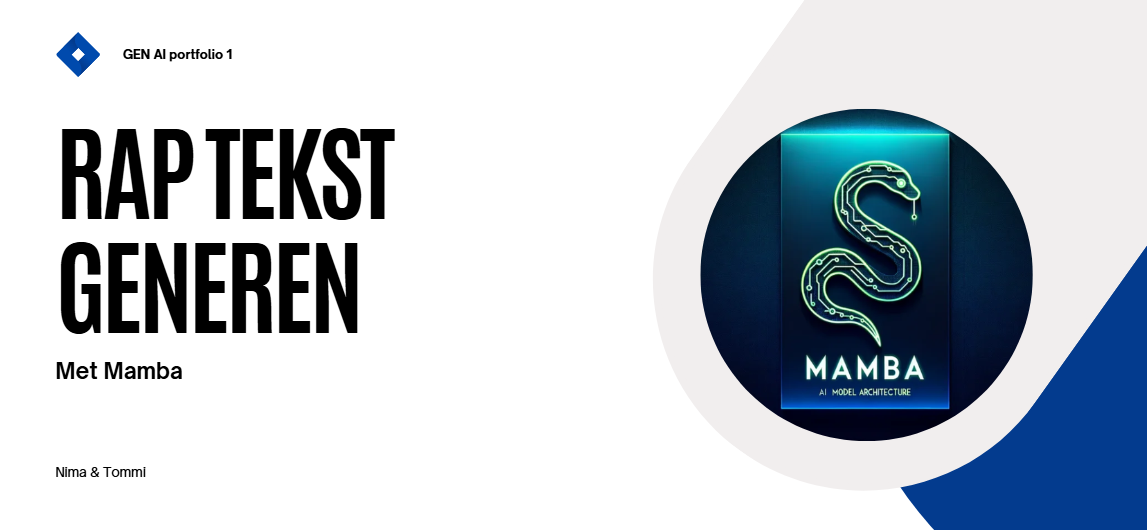

In [1]:
import numpy as np
import tensorflow as tf
import math
import kagglehub
import pandas as pd

In [3]:
path = kagglehub.dataset_download("jamiewelsh2/rap-lyrics")
#path = "d:/HHS/GENAI/Project - Mamba"
print("Path to dataset files:", path)


# Dataset inladen
df = pd.read_csv(path + "/updated_rappers.csv")
display(df.head())

Path to dataset files: C:\Users\Nima\.cache\kagglehub\datasets\jamiewelsh2\rap-lyrics\versions\1


,Unnamed: 0,artist,song,lyric,next lyric
0,0,Fetty Wap,Trap Queen,rgf productions,remy boyz yahah
1,0,Fetty Wap,Trap Queen,remy boyz yahah,1738 ayy
2,0,Fetty Wap,Trap Queen,1738 ayy,im like hey whats up hello
3,0,Fetty Wap,Trap Queen,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,0,Fetty Wap,Trap Queen,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll


In [4]:
# Data inladen
def load_data(path):
    """
    Laadt een CSV-bestand met raplyrics en verwijdert lege waarden.

    Parameters:
    path (str): Het pad naar de map met het CSV-bestand.

    Returns:
    pd.DataFrame: Een dataframe met twee kolommen: 'lyric' en 'next lyric'.
    """
    df = pd.read_csv(path + "/updated_rappers.csv")
    df = df[['lyric', 'next lyric']].dropna()
    return df

df = load_data(path)
display(df.head())

,lyric,next lyric
0,rgf productions,remy boyz yahah
1,remy boyz yahah,1738 ayy
2,1738 ayy,im like hey whats up hello
3,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll


#### Preprocess_text
In deze functie wordt de tekst getokenized en wordt er een vocabulaire gemaakt. Hier gebeurd het volgende:
    
De tekst wordt omgezet naar kleine letters. Dat gebeurd in de eerste regel (words = text.lower().split()).
Er wordt een vocabulaire gemaakt van alle unieke woorden in de tekst. Dit gebeurd in de tweede regel (vocab = sorted(set(words))).
Er wordt een dictionary gemaakt die woorden omzet naar indices. Dit betekent dat elk woord in de tekst een unieke index krijgt. Dit gebeurd in de derde regel (word2idx = {word: i for i, word in enumerate(vocab)}).
Er wordt een dictionary gemaakt die indices omzet naar woorden. Dit gebeurd in de vierde regel (idx2word = {i: word for i, word in enumerate(vocab)}).
Er wordt een array gemaakt van indices die de woorden in de tekst vervangen. Dit gebeurd in de vijfde regel (tokens = np.array([word2idx[word] for word in words], dtype=np.int32)).
De functie geeft de tokens, word2idx en idx2word terug.

#### Create_batches

In de functie wordt de tekst opgedeeld in batches van grootte batch_size x seq_length. Hierbij gebeurd het volgende:
    
De tekst wordt opgedeeld in batches van grootte batch_size x seq_length. Dit gebeurd in de regel tokens.reshape((batch_size, -1)).
Voor iedere batch wordt de input en output gemaakt. De input is de tekst van index i tot i + seq_length en de output is de tekst van index i + 1 tot i + seq_length + 1. 
Dit betekent eigenlijk dat de output de input is, maar dan 1 stap verder in de tekst.
De input en output worden gereturned als x_batch en y_batch.

In [5]:
def preprocess_text(text):
    """
    Zet tekst om in een lijst van unieke woorden en maakt een woordenboek met bijbehorende nummers.

    Parameters:
    text (str): De invoertekst die wordt omgezet.

    Returns:
    tuple: 
        - tokens (np.array): Een lijst van getallen die de woorden in de tekst vertegenwoordigen.
        - word2idx (dict): Een woordenboek dat elk woord een uniek nummer geeft.
        - idx2word (dict): Een omgekeerd woordenboek dat elk nummer terugvertaalt naar het bijbehorende woord.
    """
    words = text.lower().split()
    vocab = sorted(set(words))
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for i, word in enumerate(vocab)}
    tokens = np.array([word2idx[word] for word in words], dtype=np.int32)
    return tokens, word2idx, idx2word

def create_batches(tokens, batch_size, seq_length):
    """
    Verdeelt de tokens in kleine stukjes (batches) om het model te trainen.

    Parameters:
    tokens (np.array): De lijst met getallen die de woorden in de tekst vertegenwoordigen.
    batch_size (int): Hoeveel voorbeeldzinnen per batch worden gebruikt.
    seq_length (int): De lengte van elke trainingsreeks.

    Returns:
    generator: Geeft bij elke oproep een nieuwe batch van input- en outputgegevens terug.
    """
    n_batches = len(tokens) // (batch_size * seq_length)
    tokens = tokens[:n_batches * batch_size * seq_length]
    x = tokens.reshape((batch_size, -1))
    for i in range(0, x.shape[1] - seq_length, seq_length):
        x_batch = x[:, i:i+seq_length]
        y_batch = x[:, i+1:i+seq_length+1]
        yield x_batch, y_batch

In [6]:
class Mamba(tf.Module):
    def __init__(self, vocab_size, embed_dim, name=None):
        super(Mamba, self).__init__(name=name)
        # Embedding matrix: zet tokenindices om in vectoren.
        self.embedding = tf.Variable(tf.random.uniform([vocab_size, embed_dim], -0.1, 0.1), name="embedding")
        # Gate parameters voor het selectie-mechanisme. Dit bepaald hoeveel van de nieuwe informatie wordt toegevoegd aan de hidden state.
        self.W_gate = tf.Variable(tf.random.uniform([embed_dim, embed_dim], -0.1, 0.1), name="W_gate")
        self.b_gate = tf.Variable(tf.zeros([embed_dim]), name="b_gate")
        # Output naar de vocabulaire-dimensie.
        self.W_out = tf.Variable(tf.random.uniform([embed_dim, vocab_size], -0.1, 0.1), name="W_out")
        self.b_out = tf.Variable(tf.zeros([vocab_size]), name="b_out")
        
    def __call__(self, inputs, initial_state=None):
        # inputs: shape (batch_size, seq_length) met token indices.
        # initial_state: shape (batch_size, embed_dim); Als er niks wordt doorgegeven wordt de state op 0 gezet.
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        x_embed = tf.nn.embedding_lookup(self.embedding, inputs)  
        
        if initial_state is None:
            h = tf.zeros([batch_size, x_embed.shape[-1]], dtype=tf.float32)
        else:
            h = initial_state
        
        outputs = []
        # Itereer over de tijdstappen.
        for t in range(seq_length):
            x_t = x_embed[:, t, :]
            g_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_gate) + self.b_gate)
            h = (1 - g_t) * h + g_t * x_t
            # Bereken de output op basis van de hidden state.
            logits = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(logits)
        # Zet de outputs samen: (batch_size, seq_length, vocab_size)
        logits_seq = tf.stack(outputs, axis=1)
        return logits_seq, h
    
    def generate(self, start_word, word2idx, idx2word, num_words, temperature=1.0):
        # Verzin een tekstreeks op basis van een beginwoord.
        current_word = start_word.lower()
        generated = [current_word]
        # Initialiseer de state.
        h = tf.zeros([1, self.embedding.shape[1]], dtype=tf.float32)
        token = word2idx.get(current_word, 0)
        for _ in range(num_words - 1):
            x_t = tf.nn.embedding_lookup(self.embedding, [token])  
            g_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_gate) + self.b_gate)  
            h = (1 - g_t) * h + g_t * x_t
            logits = tf.matmul(h, self.W_out) + self.b_out 
            logits = logits / temperature
            prob = tf.nn.softmax(logits)
            # Sample de volgende token.
            token = tf.random.categorical(tf.math.log(prob), num_samples=1)[0, 0].numpy()
            word = idx2word[token]
            generated.append(word)
        return ' '.join(generated), len(generated)
    
#Bronnen: 

#(GeeksforGeeks, 2021)
#(What Does tf.nn.embedding_lookup Function Do?, n.d.)
#(Introduction to Variables, n.d.)
#(tf.zeros, n.d.)
#(tf.random.categorical, n.d.)
#(ChatGPT, Maart 2025 - Prompt 1: Hoe zou jij een mamba... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1), 
#(ChatGPT, Maart 2025 - Prompt 2: Ik wil dat je in de class functie... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)

In [7]:
# training_data
training_text = df['lyric'].str.cat(sep=' ')

sample_text = training_text[:100000]

In [9]:
tokens, word2idx, idx2word = preprocess_text(sample_text)
vocab_size = len(word2idx)
embed_dim = 32 

model = Mamba(vocab_size, embed_dim)

batch_size = 2
seq_length = 5
learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate)

history = {'loss': []} 

for epoch in range(10):
    total_loss = 0
    count = 0
    for x_batch, y_batch in create_batches(tokens, batch_size, seq_length):
        with tf.GradientTape() as tape:
            logits, _ = model(x_batch)
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_batch, logits=logits))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        total_loss += loss.numpy()
        count += 1
    epoch_loss = total_loss / count
    history['loss'].append(epoch_loss)  
    print("Epoch", epoch+1, "Loss:", epoch_loss)


start_word = "pretty"
generated_text, word_count = model.generate(start_word, word2idx, idx2word, num_words=15)
print("Output: ", generated_text)
print("Aantal woorden:", word_count)

#(Writing a Training Loop From Scratch, n.d.)

Epoch 1 Loss: 5.244880871474743
Epoch 2 Loss: 3.9140947831408033
Epoch 3 Loss: 3.326901193405941
Epoch 4 Loss: 2.9783688262421286
Epoch 5 Loss: 2.762384736854232
Epoch 6 Loss: 2.6150342189724434
Epoch 7 Loss: 2.517532685752255
Epoch 8 Loss: 2.43951385590898
Epoch 9 Loss: 2.3792164331864356
Epoch 10 Loss: 2.3266085764709508
Output:  pretty ass why i told nittdagritt that we gon need the back thats foolish i
Aantal woorden: 15


In [32]:

start_word = "Can you"
generated_text, word_count = model.generate(start_word, word2idx, idx2word, num_words=30)
print("Output: ", generated_text)
print("Aantal woorden:", word_count)

Output:  can you down when its sunny and honey got the back control us ayy zoogang we came up learn to afford it with christmas its true and all i done smoked
Aantal woorden: 30


### VISUALISATIE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()


def visualize_embeddings(embedding_matrix, word2idx, method='tsne'):
    words = list(word2idx.keys())[:500] 
    vectors = np.array([embedding_matrix[word2idx[word]] for word in words])
    
    if method == 'tsne':
        reduced_vectors = TSNE(n_components=2, random_state=42).fit_transform(vectors)
    else:
        reduced_vectors = PCA(n_components=2).fit_transform(vectors)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5)
    
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)
    
    plt.title(f'Word Embedding Visualization ({method.upper()})')
    plt.show()

    #(ChatGPT, 2025 - Prompt 3: Verschillende evaluatiemethoden... https://chatgpt.com/share/67d810f7-186c-800d-a276-be1ce07f6731

In [ ]:
embedding_matrix = model.embedding.numpy()

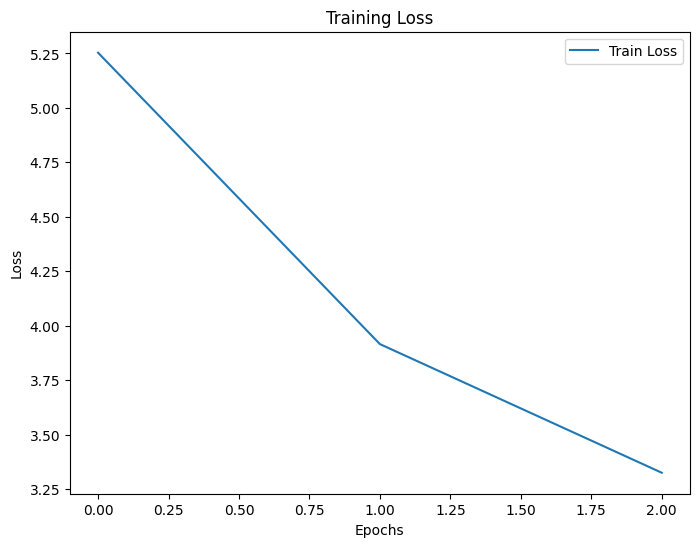

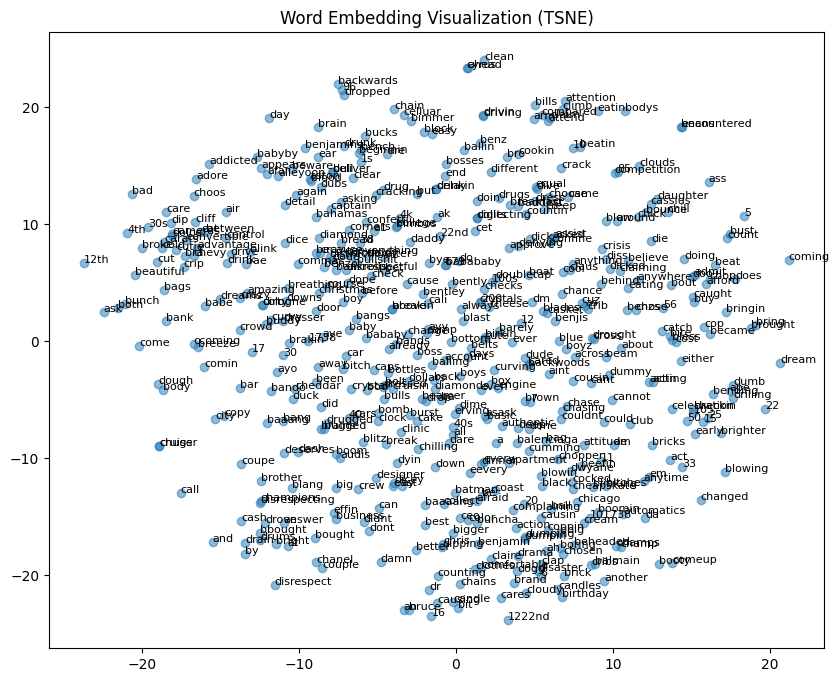

In [ ]:
plot_loss(history) 

visualize_embeddings(embedding_matrix, word2idx, method='tsne') 

# Het Mamba model-architectuuruitleg

##  **Constructormethode**
De constructor (`__init__`) wordt gebruikt om het model te initialiseren. Hier worden de kernparameters en variabelen van het model gedefinieerd die tijdens het trainen en genereren worden gebruikt.  

### **1. Embedding matrix definiëren**
```python
self.embedding = tf.Variable(tf.random.uniform([vocab_size, embed_dim], -0.1, 0.1), name="embedding")
```
- **Wat betekent het?**  
  - `self.embedding` is een matrix waarin tokens (woorden) worden omgezet naar vectoren.
  - `tf.Variable` maakt een TensorFlow-variabele aan die tijdens het trainen kan worden geüpdatet.
  - `tf.random.uniform` initialiseert de matrix met willekeurige waarden tussen -0.1 en 0.1.
  - `vocab_size` = grootte van de woordenschat (hoeveel verschillende tokens het model kent).  
  - `embed_dim` = grootte van de vector waarmee elk token wordt gerepresenteerd.

- **Wat doet het?**  
  De embedding matrix zet discrete token indices (zoals het woord "cat" dat wordt weergegeven als een nummer) om in vectoren (reeks van getallen). Hierdoor kunnen woorden worden verwerkt als numerieke waarden.

- **Waarom belangrijk?**  
  Het model werkt met numerieke gegevens, niet met tekst. Door embeddings te gebruiken, kan het model semantische relaties tussen woorden leren.

- **Waarom deze aanpak?**  
  Willekeurige initialisatie zorgt ervoor dat het model niet met vooroordelen begint en geleidelijk de embeddings leert door middel van backpropagation.

---

### **2. Gate parameters definiëren**
```python
self.W_gate = tf.Variable(tf.random.uniform([embed_dim, embed_dim], -0.1, 0.1), name="W_gate")
self.b_gate = tf.Variable(tf.zeros([embed_dim]), name="b_gate")
```
- **Wat betekent het?**  
  - `self.W_gate` = gewichtsmatrix voor het selectie-mechanisme (gate).  
  - `self.b_gate` = bias vector voor de gate.  
  - `tf.random.uniform` initialiseert de gewichten willekeurig tussen -0.1 en 0.1.  
  - `tf.zeros` initialiseert de bias met nullen.  

- **Wat doet het?**  
  De gate bepaalt welke informatie wordt doorgegeven en welke wordt genegeerd. De sigmoid-functie zet de uitkomst van de gate om naar waarden tussen 0 en 1, zodat het model kan beslissen hoeveel van de huidige input of vorige state het wil behouden.  

- **Waarom belangrijk?**  
  Het selectie-mechanisme zorgt ervoor dat het model alleen nuttige informatie behoudt en irrelevante informatie weglaat. Dit voorkomt dat het model overweldigd raakt door onbelangrijke details.  

- **Waarom deze aanpak?**  
  Gate-mechanismen zijn cruciaal in sequentiële modellen (zoals LSTM's) omdat ze helpen bij het vasthouden van nuttige informatie en het vergeten van ruis.

---

### **3. Output projectie parameters definiëren**
```python
self.W_out = tf.Variable(tf.random.uniform([embed_dim, vocab_size], -0.1, 0.1), name="W_out")
self.b_out = tf.Variable(tf.zeros([vocab_size]), name="b_out")
```
- **Wat betekent het?**  
  - `self.W_out` = projectiematrix van verborgen toestand naar output logits.  
  - `self.b_out` = biasvector voor de output.  

- **Wat doet het?**  
  De verborgen toestand (`hidden state`) wordt door de gewichten en bias omgezet naar een output die overeenkomt met de woordenschat (vocabulaire).  

- **Waarom belangrijk?**  
  Dit is de laatste stap waarbij het model probeert het volgende woord te voorspellen op basis van de interne toestand.  

- **Waarom deze aanpak?**  
  De lineaire transformatie zorgt ervoor dat de verborgen toestand correct wordt vertaald naar de ruimte van mogelijke woorden in de woordenschat.  

---

##  **Call-methode**  
De `__call__` methode voert de daadwerkelijke verwerking van de sequenties uit en wordt aangeroepen wanneer het model wordt getraind of getest.

### **1. Inputs en initiële staat bepalen**
```python
if initial_state is None:
    h = tf.zeros([batch_size, x_embed.shape[-1]], dtype=tf.float32)
else:
    h = initial_state
```
- **Wat betekent het?**  
  - `initial_state` is de toestand van het model bij de start van de verwerking.  
  - `tf.zeros` creëert een beginstaat gevuld met nullen.  

- **Wat doet het?**  
  Als er geen initiële toestand is, begint het model met een neutrale staat (alle waarden op nul).  

- **Waarom belangrijk?**  
  Het bepalen van een beginstaat is cruciaal voor sequentiële verwerking, omdat het model moet weten hoe het begint.  

- **Waarom deze aanpak?**  
  Een neutrale staat zorgt ervoor dat het model geen vooringenomenheid heeft aan het begin van de verwerking.  

---

### **2. Dimensies van de input bepalen**
```python
batch_size = tf.shape(inputs)[0]
seq_length = tf.shape(inputs)[1]
```
- **Wat betekent het?**  
  - `batch_size` = aantal sequenties dat tegelijkertijd wordt verwerkt.  
  - `seq_length` = lengte van elke sequentie (hoeveel tokens).  

- **Wat doet het?**  
  Het bepaalt de vorm van de invoer zodat het model de juiste berekeningen kan maken.  

- **Waarom belangrijk?**  
  De dimensies zijn nodig voor matrixvermenigvuldigingen en andere operaties.  

- **Waarom deze aanpak?**  
  TensorFlow vereist dat de vormen correct zijn voor batch- en sequentieverwerking.  

---

### **3. Inputs embedden**
```python
x_embed = tf.nn.embedding_lookup(self.embedding, inputs)
```
- **Wat betekent het?**  
  - `tf.nn.embedding_lookup` haalt de vectorrepresentaties op uit de embedding-matrix.  

- **Wat doet het?**  
  Het zet token-indices om in vectoren.  

- **Waarom belangrijk?**  
  Het model werkt met vectoren, niet met indices of tekst.  

- **Waarom deze aanpak?**  
  `embedding_lookup` is efficiënt en geoptimaliseerd voor GPU-verwerking.  

---

### **4. For-loop voor tijdstappen**
```python
for t in range(seq_length):
```
- **Wat betekent het?**  
  - Loopt door elk tijdstip in de invoersequentie.  

- **Wat doet het?**  
  Voert verwerkingsstappen uit voor elk token.  

- **Waarom belangrijk?**  
  Sequentiële verwerking vereist iteratie over de invoer.  

- **Waarom deze aanpak?**  
  Tijdstapverwerking is standaard voor sequentiemodellen.  

---

### **5. Gate berekenen**
```python
g_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_gate) + self.b_gate)
```
- **Wat betekent het?**  
  - Sigmoid zet de waarde om naar iets tussen 0 en 1.  

- **Wat doet het?**  
  Beslist welke informatie wordt behouden of genegeerd.  

- **Waarom belangrijk?**  
  Het model leert welke informatie nuttig is.  

- **Waarom deze aanpak?**  
  Sigmoid is geschikt voor binaire beslissingen.  

---

### **6. Hidden state updaten**
```python
h = (1 - g_t) * h + g_t * x_t
```
- **Wat betekent het?**  
  - Update op basis van gate-uitgang.  

- **Wat doet het?**  
  Combineert oude toestand met nieuwe informatie.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat nuttige informatie behouden blijft.  

- **Waarom deze aanpak?**  
  Dit is de kern van het Mamba-model.  






##  **Generate-methode**
De `generate()`-methode zorgt ervoor dat het model sequenties (bijvoorbeeld rapteksten) kan genereren door tokens één voor één te voorspellen op basis van de interne toestand (`hidden state`).

---

### **1. Beginwaarde voor de interne toestand bepalen**
```python
if initial_state is None:
    h = tf.zeros([1, self.embedding.shape[-1]], dtype=tf.float32)
else:
    h = initial_state
```
- **Wat betekent het?**  
  - `initial_state` = begintoestand van het model.  
  - `tf.zeros` initialiseert de begintoestand als een vector met alleen nullen.  
  - `self.embedding.shape[-1]` geeft de dimensie van de embedding weer (de grootte van elke vector).  

- **Wat doet het?**  
  Het bepaalt de interne toestand (`hidden state`) aan het begin van het generatieproces.  

- **Waarom belangrijk?**  
  Het model moet vanuit een consistente toestand starten om betekenisvolle tekst te genereren.  

- **Waarom deze aanpak?**  
  Een nultoestand zorgt ervoor dat het model geen vooringenomenheid heeft bij het genereren van de eerste token.  

---

### **2. Lijst voor de output tokens aanmaken**
```python
generated_tokens = []
```
- **Wat betekent het?**  
  - `generated_tokens` = lege lijst waarin de gegenereerde tokens worden opgeslagen.  

- **Wat doet het?**  
  Slaat elk gegenereerd token op zodat het later kan worden samengevoegd tot tekst.  

- **Waarom belangrijk?**  
  Om tekst te genereren, moeten de tokens achter elkaar worden gezet.  

- **Waarom deze aanpak?**  
  Een lijst biedt een efficiënte manier om tokens op te slaan en uit te breiden.  

---

### **3. Loop voor het genereren van tokens**
```python
for _ in range(max_length):
```
- **Wat betekent het?**  
  - Loopt door totdat het maximaal aantal tokens (`max_length`) is bereikt.  

- **Wat doet het?**  
  Zorgt ervoor dat de tekstgeneratie stopt na een bepaalde lengte.  

- **Waarom belangrijk?**  
  Voorkomt dat het model oneindig blijft genereren.  

- **Waarom deze aanpak?**  
  Het instellen van een limiet zorgt voor controle over de lengte van de uitvoer.  

---

### **4. Embed het vorige token (of het starttoken)**
```python
x_t = tf.nn.embedding_lookup(self.embedding, start_token if len(generated_tokens) == 0 else generated_tokens[-1])
```
- **Wat betekent het?**  
  - `tf.nn.embedding_lookup` haalt de vectorrepresentatie van het token op uit de embedding-matrix.  
  - `start_token` = eerste token dat de generatie start (bijvoorbeeld een speciaal `<START>`-token).  
  - `generated_tokens[-1]` = het laatst gegenereerde token.  

- **Wat doet het?**  
  Converteert het token naar de bijbehorende vector zodat het model ermee kan werken.  

- **Waarom belangrijk?**  
  Het model werkt met vectoren, niet met tekst.  

- **Waarom deze aanpak?**  
  Het gebruik van embeddings zorgt ervoor dat het model betekenisvolle relaties tussen tokens leert.  

---

### **5. Gate-mechanisme toepassen**
```python
g_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_gate) + self.b_gate)
```
- **Wat betekent het?**  
  - `tf.matmul` = matrixvermenigvuldiging tussen de input en de gate-gewichten.  
  - `tf.nn.sigmoid` = zet waarden om naar een bereik tussen 0 en 1.  
  - `self.b_gate` = bias voor de gate.  

- **Wat doet het?**  
  De gate bepaalt hoeveel van de vorige toestand wordt behouden en hoeveel van de nieuwe input wordt meegenomen.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat het model alleen relevante informatie behoudt.  

- **Waarom deze aanpak?**  
  Gate-mechanismen zijn effectief in het modelleren van sequentiële afhankelijkheden.  

---

### **6. Hidden state updaten**
```python
h = (1 - g_t) * h + g_t * x_t
```
- **Wat betekent het?**  
  - `(1 - g_t)` = bepaalt hoeveel van de oude toestand behouden blijft.  
  - `g_t * x_t` = bepaalt hoeveel van de nieuwe informatie wordt toegevoegd.  

- **Wat doet het?**  
  Update de verborgen toestand door een combinatie van oude en nieuwe informatie.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat het model informatie over langere tijd behoudt.  

- **Waarom deze aanpak?**  
  Dit is het kernidee van het Mamba-model — het leert welke informatie relevant is.  

---

### **7. Output logits berekenen**
```python
logits = tf.matmul(h, self.W_out) + self.b_out
```
- **Wat betekent het?**  
  - `tf.matmul(h, self.W_out)` = matrixvermenigvuldiging van verborgen toestand naar outputruimte.  
  - `self.b_out` = bias voor de outputruimte.  

- **Wat doet het?**  
  Zet de verborgen toestand om naar een ruwe voorspelling (`logits`) over de mogelijke tokens.  

- **Waarom belangrijk?**  
  De logits worden gebruikt om het volgende token te voorspellen.  

- **Waarom deze aanpak?**  
  Een lineaire transformatie is standaard voor outputlaag in taalmodellen.  

---

### **8. Softmax toepassen om waarschijnlijkheden te krijgen**
```python
probs = tf.nn.softmax(logits)
```
- **Wat betekent het?**  
  - `tf.nn.softmax` zet logits om naar waarschijnlijkheden.  

- **Wat doet het?**  
  Geeft waarschijnlijkheden voor elk token in de woordenschat.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat de voorspelling een geldige kansverdeling is.  

- **Waarom deze aanpak?**  
  Softmax wordt standaard gebruikt voor classificatie.  

---

### **9. Token met hoogste waarschijnlijkheid kiezen**
```python
next_token = tf.argmax(probs, axis=-1).numpy()[0]
```
- **Wat betekent het?**  
  - `tf.argmax` kiest het token met de hoogste kans.  

- **Wat doet het?**  
  Selecteert het meest waarschijnlijke volgende token.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat het model consistent tekst genereert.  

- **Waarom deze aanpak?**  
  `argmax` is efficiënt voor het kiezen van het hoogste scorende token.  

---

### **10. Token toevoegen aan de output**
```python
generated_tokens.append(next_token)
```
- **Wat betekent het?**  
  - `append()` voegt het gekozen token toe aan de outputlijst.  

- **Wat doet het?**  
  Houdt de gegenereerde tekst bij.  

- **Waarom belangrijk?**  
  Het model moet weten wat het al heeft gegenereerd om coherente tekst te maken.  

- **Waarom deze aanpak?**  
  Lijsten zijn handig voor het opslaan van variabele hoeveelheden tokens.  





---

### **12. Retourneer de volledige gegenereerde tekst**
```python
return generated_tokens
```
- **Wat betekent het?**  
  - Geeft de lijst met tokens terug.  

- **Wat doet het?**  
  Maakt de gegenereerde tekst beschikbaar voor gebruik.  

- **Waarom belangrijk?**  
  Zorgt ervoor dat het model tekst kan produceren die elders gebruikt kan worden.  




### Tabel mamba class

| **Codeonderdeel**             | **Code (codeblock)**                                                                                                                                                                                                                                             | **Wat het doet**                                                                                                                                             | **Quote / idee uit de paper**                                                                                                                                                                                       | **Nieuwe paginaverwijzing** | **Waarom gebruiken we deze code?**                                                                                                                                                                                                                                                                           |
|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Embedding**                 | ``` x_embed = tf.nn.embedding_lookup(self.embedding, inputs)```                                                                                                                                                                                       | Zet de getallen (tokenindices) om in vectoren zodat de computer de betekenis van elk woord kan begrijpen.                                                    | *"We simplify this architecture ... tokens are projected into a higher-dimensional space."* (Algemene uitleg over invoerprojectie in de architectuur)                                                          | Pagina 7                    | We gebruiken `tf.nn.embedding_lookup` omdat dit snel voor elk woord de juiste vector (vergelijkbaar met een woordenboek) opzoekt, zodat het model met betekenisvolle getallen werkt. Tensorflow tf nn.embedding_lookup. (2018, July 20). Artificial Intelligence Research. https://ai-mrkogao.github.io/tensorflow/tfnnembeddinglookup/                                                                                                                  |
| **Hidden state initialisatie**| ```if initial_state is None: h = tf.zeros(...)```                                                                                        | Initialiseert het interne geheugen (de verborgen staat) met nullen als er nog geen eerdere informatie is.                                                    | *"Concretely, S4 models are defined ... the hidden state is computed recurrently."* (Basisidee dat de toestand telkens opnieuw wordt berekend in een SSM)                                                       | Pagina 7                    | We gebruiken `tf.zeros` om te beginnen met een lege geheugenruimte, zodat er geen oude informatie mee vermengd wordt in de eerste stap.                                                                                                                     |
| **Gate berekening**           | ```g_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_gate) + self.b_gate)```                                                                                                                                                                                 | Bereken een getal tussen 0 en 1 voor elke invoer \(x_t\) dat bepaalt hoeveel van de nieuwe informatie in het geheugen komt.                                     | *"g_t = σ(Linear(x_t))"* (Theorem 1: het selectiemechanisme dat bepaalt welke informatie belangrijk is)                                                                                                          | Pagina 28                   | Met `tf.matmul` vermenigvuldigen we de invoer met een set gewichten, en `tf.nn.sigmoid` zorgt dat de uitkomst altijd tussen 0 en 1 ligt. Zo kiezen we precies hoeveel van de nieuwe info we willen meenemen.                                                                             |
| **Hidden state update**       | ```h = (1 - g_t) * h + g_t * x_t```                                                                                                                                                                                                                 | Update de verborgen staat door een mix te maken: een deel komt uit het oude geheugen en een deel uit de nieuwe invoer, afhankelijk van de waarde van \(g_t\). | *"h_t = (1 - g_t) h_{t-1} + g_t x_t"* (Theorem 1: hiermee combineren we oude en nieuwe informatie op een slimme manier)                                                                                           | Pagina 28                   | Deze regel zorgt ervoor dat als de gate hoog is (veel nieuwe info), de nieuwe invoer zwaar meeweegt; is de gate laag, dan blijft vooral de oude informatie behouden. Dit maakt de update heel flexibel en leerbaar.                                                                    |
| **Output projectie**          | ```logits = tf.matmul(h, self.W_out) + self.b_out```                                                                                                                                                                                                 | Zet de interne verborgen staat om in scores (logits) voor elk woord in het vocabulaire, zodat we kunnen bepalen welk woord het beste past.                   | *"The output projection maps the hidden state to the vocabulary dimension."* (Uitleg over de outputlaag in de architectuur)                                                                                         | Pagina 7                    | We gebruiken deze lineaire projectie omdat dit een standaard manier is om de interne representatie om te zetten naar voorspellingen voor elk woord, zodat we de beste keuze kunnen maken via bijvoorbeeld een softmax.                                                                   |
| **Autoregressieve generatie** | ```Generate functie``` | Genereert stap voor stap een tekst: bij elke stap wordt het vorige woord opnieuw gebruikt om het volgende woord te voorspellen via dezelfde stappen.          | *"Unrolling the model autoregressively ... each step uses the same recurrence."* (Het idee dat we telkens dezelfde eenvoudige stap herhalen om nieuwe woorden te genereren)                                 | Pagina 8                    | Deze aanpak is efficiënt omdat het model telkens alleen de nieuwe stap berekent op basis van de vorige, zonder alles opnieuw te moeten berekenen. Zo kan het model snel en stap voor stap een zin of verhaal genereren.                                                                 |





### **Bronnen**

- (ChatGPT, Maart 2025 - Prompt 1: Hoe zou jij een mamba... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)

- (ChatGPT, Maart 2025 - Prompt 2: Ik wil dat je in de class functie... https://chatgpt.com/share/67df010c-c968-8013-8bbc-f9f92fe51fa1)

- (ChatGPT, Maart 2025 - Prompt 3: Verschillende evaluatiemethoden... https://chatgpt.com/share/67d810f7-186c-800d-a276-be1ce07f6731)

- GeeksforGeeks. (2021, May 18). Tensorflow.js TF.MatMuL() function. GeeksforGeeks. https://www.geeksforgeeks.org/tensorflow-js-tf-matmul-function/

- GeeksforGeeks. (2021, May 18). Tensorflow.js tf.randomUniform() Function. GeeksforGeeks. https://www.geeksforgeeks.org/tensorflow-js-tf-randomuniform-function/

- GeeksforGeeks. (2021, December 12). Python | Tensorflow nn.sigmoid(). GeeksforGeeks. https://www.geeksforgeeks.org/python-tensorflow-nn-sigmoid/

- GeeksforGeeks. (2021, December 13). Python | Tensorflow log() method. GeeksforGeeks. https://www.geeksforgeeks.org/python-tensorflow-log-method/

- Introduction to variables. (n.d.). TensorFlow. https://www.tensorflow.org/guide/variable

- Tf.zeros. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/zeros

- tf.random.categorical. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/random/categorical

- What does tf.nn.embedding_lookup function do? (n.d.). Stack Overflow. https://stackoverflow.com/questions/34870614/what-does-tf-nn-embedding-lookup-function-do

- Writing a training loop from scratch. (n.d.). TensorFlow. https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?utm_source=chatgpt.com